<a href="https://colab.research.google.com/github/godpeny/laboratory/blob/master/Study/Deep_Learning_for_Everyone/Chapter_5/transfer_learning_with_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install
%pip install pandas
%pip install numpy
%pip install tensorflow
%pip install sklearn
%pip install matplotlib

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [2]:
# import
import pandas as pd
import numpy as np

from google.colab import drive

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, LeakyReLU, BatchNormalization, Reshape, Activation, UpSampling2D, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers, Input, models, layers, metrics
from tensorflow.keras.applications import VGG16

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [3]:
# load data sets from Google Drive
drive.mount('/d')
train_data_path = '/d/My Drive/Colab Notebooks/DL-tutorial/data/brain/train'
test_data_path = '/d/My Drive/Colab Notebooks/DL-tutorial/data/brain/test'

Drive already mounted at /d; to attempt to forcibly remount, call drive.mount("/d", force_remount=True).


In [4]:
"""
generating image data
"""

# data generated with augmented option
train_data_generator = ImageDataGenerator(rescale=1./255, horizontal_flip=True, width_shift_range=0.1, height_shift_range=0.1)
train_data = train_data_generator.flow_from_directory(directory=train_data_path, target_size=(150, 150), batch_size=5, class_mode='binary') # class_moce='binary': normal, abnormal binary selection

test_data_generator = ImageDataGenerator(rescale=1./255) # augmentation is not used in test data sets
test_data = test_data_generator.flow_from_directory(directory=test_data_path, target_size=(150, 150), batch_size=5, class_mode='binary')

Found 160 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


#transfer learning vs fine tuning
https://vitalflux.com/transfer-learning-vs-fine-tuning-differences/#:~:text=Transfer%20Learning%3A%20Focuses%20on%20transferring,model%20to%20a%20particular%20task.

In [5]:
"""
use VGG16 model for transfer learning
"""
transfer_model = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3)) # 'inclue_top=False' to use my fine-tuning model.
transfer_model.trainable = False # transfer model does not train.

In [6]:
"""
use my model for fine-tuning
"""
ft_model = Sequential()
ft_model.add(transfer_model)
ft_model.add(Flatten())
ft_model.add(Dense(64, activation='relu'))
ft_model.add(Dropout(0.5))
ft_model.add(Dense(1, activation='sigmoid'))
ft_model.summary()

ft_model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0002), metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 64)                524352    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 15239105 (58.13 MB)
Trainable params: 524417 (2.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [7]:
"""
checkpointers
"""
early_stopping_checkpointer = EarlyStopping(patience=5) # monitor 'val_loss' for default.

In [8]:
"""
training model
"""
history = ft_model.fit(train_data, epochs=100, validation_data=test_data, validation_steps=10, callbacks=[early_stopping_checkpointer])

Epoch 1/100
32/32 [==============================] - 31s 826ms/step - loss: 0.6760 - accuracy: 0.6062 - val_loss: 0.6028 - val_accuracy: 0.6400
Epoch 2/100
32/32 [==============================] - 14s 443ms/step - loss: 0.5683 - accuracy: 0.7125 - val_loss: 0.4892 - val_accuracy: 0.8400
Epoch 3/100
32/32 [==============================] - 9s 294ms/step - loss: 0.5220 - accuracy: 0.7563 - val_loss: 0.3905 - val_accuracy: 0.9400
Epoch 4/100
32/32 [==============================] - 4s 117ms/step - loss: 0.4291 - accuracy: 0.8625 - val_loss: 0.3575 - val_accuracy: 0.9800
Epoch 5/100
32/32 [==============================] - 4s 110ms/step - loss: 0.3865 - accuracy: 0.8625 - val_loss: 0.3582 - val_accuracy: 0.8400
Epoch 6/100
32/32 [==============================] - 4s 140ms/step - loss: 0.3837 - accuracy: 0.8125 - val_loss: 0.3017 - val_accuracy: 0.9200
Epoch 7/100
32/32 [==============================] - 3s 108ms/step - loss: 0.3121 - accuracy: 0.9125 - val_loss: 0.2079 - val_accuracy: 0.96

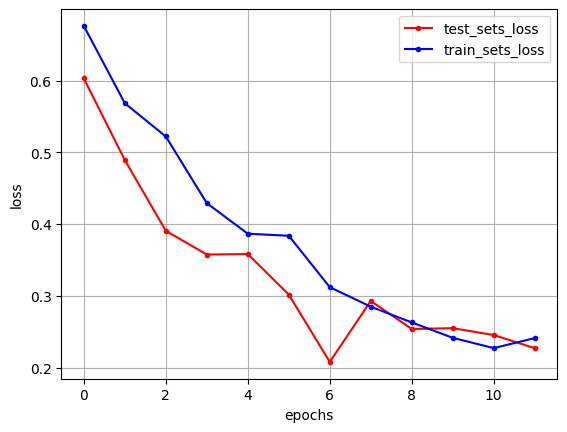

In [9]:
# show result on graph
val_loss = history.history['val_loss']
loss = history.history['loss']

x_len = np.arange(len(loss)) # 24 -> [0 1 2 3 ... 21 22 23]

plt.plot(x_len, val_loss, marker='.', c='red', label='test_sets_loss')
plt.plot(x_len, loss, marker='.', c='blue', label='train_sets_loss')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.grid()
plt.show()